In [1]:
import warnings, os, sys, glob, matplotlib, scipy
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore")
matplotlib.rcParams['pdf.fonttype'] = 42 #To make text readable by Illustrator
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, collapse_mask
from nltools.stats import threshold, fdr

In [2]:

fmri_dir="/media/haiyanwu/HDD2/xinyi_RanDishonesty/dishonesty_fMRI/"

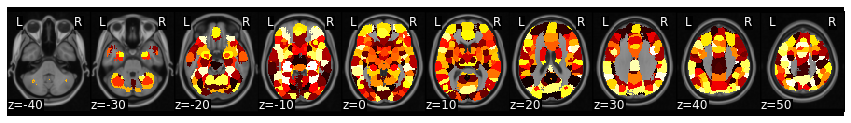

In [3]:
nparcel = 200
#nparcel=200
roi = Brain_Data('https://neurovault.org/media/images/2099/Neurosynth%20Parcellation_2.nii.gz')
#roi=Brain_Data('https://neurovault.org/media/images/1549/MMP_in_MNI_corr.nii.gz')
#roi = Brain_Data(os.path.join(fmri_dir,'5.RSA/Neurosynth_Parcellation_2.nii.gz'))
roi.plot()
roi_x = expand_mask(roi)

In [4]:

contrasts = ['lie3','hon3','lie-hon3']
metric_model = 'euclidean'
metric_brain = 'correlation'
permutation_method = 'vector'
n_permute = 100000
parcels = range(nparcel)
thresh = 0.05


In [5]:
def ensure_dir(path):
    d = os.path.dirname(path)
    if not os.path.exists(d):
        os.makedirs(d)

processing contrast lie3


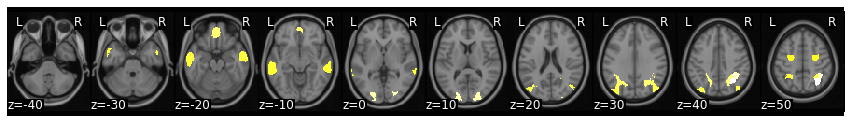

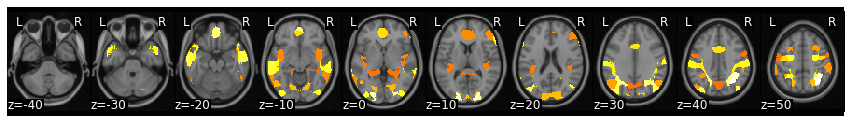

processing contrast hon3


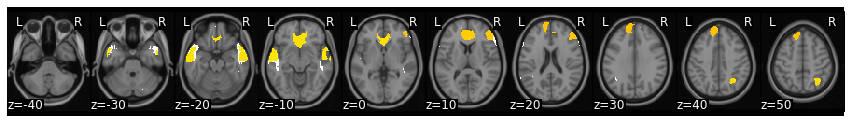

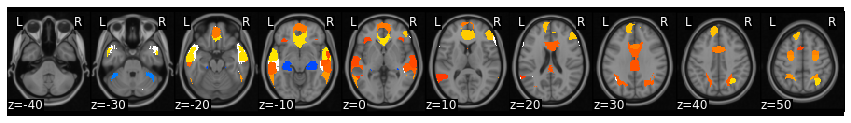

In [8]:



for contrast in ['lie3','hon3']:
    print('processing contrast %s'%(contrast))
    roi_r = roi.copy()
    roi_p = roi.copy()
    results_allparcels = pd.DataFrame()
    for parcel in range(nparcel):
        parcelDat = pd.read_csv(os.path.join(fmri_dir,
            '5.RSA/results_ques/IS-RSA_nparcel-%03d_perm-%s_%s/parcel%03d.csv'%(
            nparcel,permutation_method,contrast,parcel)),index_col=0)
        results_allparcels = results_allparcels.append(parcelDat,ignore_index=True)
        roi_r.data[roi_x[parcel].data>0] = float(parcelDat['r'])*1000000
        roi_p.data[roi_x[parcel].data>0] = float(parcelDat['p'])*1000000
    results_allparcels.to_csv(os.path.join(fmri_dir,'5.RSA/results_ques/IS-RSA_nparcel-%03d_perm-%s_%s/'%(
            nparcel,permutation_method,contrast),'allparcels.csv'))
    roi_r.data = roi_r.data.astype(float)/1000000
    roi_p.data = roi_p.data.astype(float)/1000000
    ensure_dir(os.path.join(fmri_dir,'5.RSA/Maps_ques/Maps_nparcel-%i_perm-%s/'%(nparcel,permutation_method)))
    roi_r.write(os.path.join(fmri_dir,
        '5.RSA/Maps_ques/Maps_nparcel-%i_perm-%s/%s_R.nii.gz' % (
        nparcel,permutation_method,contrast)))
    roi_p.write(os.path.join(fmri_dir,
        '5.RSA/Maps_ques/Maps_nparcel-%i_perm-%s/%s_P.nii.gz' % (
        nparcel,permutation_method,contrast)))
    
    
    
    fdr_thresh = fdr(np.array(results_allparcels['p']),thresh)
    
    bonf_thresh = thresh/nparcel
    threshs_all = {'bonf':bonf_thresh,'fdr':fdr_thresh}
    
    for thresh_type in threshs_all:
        roi_r_thr = threshold(stat=roi_r,p=roi_p,thr=threshs_all[thresh_type])
        roi_r_thr.plot()

        plt.savefig(os.path.join(fmri_dir,
            '5.RSA/Maps_ques/Maps_nparcel-%i_perm-%s/%s_R-thr-%.2f-%s.png' % (
            nparcel,permutation_method,contrast,thresh,thresh_type)))
        plt.show()
        roi_r_thr.write(os.path.join(fmri_dir,
            '5.RSA/Maps_ques/Maps_nparcel-%i_perm-%s/%s_R-thr-%.2f-%s.nii.gz' % (
            nparcel,permutation_method,contrast,thresh,thresh_type)))
        roi_r_thr_posOnly = roi_r_thr.copy()
        roi_r_thr_posOnly.data[roi_r_thr_posOnly.data<0] = 0
        roi_r_thr_posOnly.write(os.path.join(fmri_dir,
            '5.RSA/Maps_ques/Maps_nparcel-%i_perm-%s/%s_R-thr-%.2f-%s-posOnly.nii.gz' % (
            nparcel,permutation_method,contrast,thresh,thresh_type)))

In [9]:
# How many significant effects?
import nltools;
import warnings
warnings.filterwarnings('ignore')

thresh = 0.05
thresh_type = 'fdr'
permutation_method = 'vector'

    
for contrast in ['lie3','hon3']:
    print('computing significant effects of contrast %s'%(contrast))
    
    results = pd.read_csv(os.path.join(fmri_dir,
    '5.RSA/results_ques/IS-RSA_nparcel-%03d_perm-vector_%s'%(
        nparcel, contrast),'allparcels.csv'),
                        index_col=0)
    

    if thresh_type == 'fdr':
        results['sig'] = results['p']<=(fdr(np.array(results['p']),0.05))
    elif thresh_type == 'bonf':
        results['sig'] = results['p']<=(0.05/nparcel)

    
    print(results.sig.sum())

    results['sig_pos'] = np.multiply(results['sig'],results['r']>0)

    print(results.sig_pos.sum())
    print(results[results.sig_pos].r.mean())

computing significant effects of contrast lie3
33
33
0.1684093025873781
computing significant effects of contrast hon3
28
26
0.17581308342753624


In [69]:
contrast='hon3'

In [70]:
from nilearn.plotting import plot_stat_map


permutation_method = 'vector'

from numpy.polynomial.polynomial import polyfit
thresh = 0.05


all_r = pd.DataFrame(columns=['Parcel','r','p'])

results = pd.read_csv(os.path.join(fmri_dir,
    '5.RSA/results/IS-RSA_nparcel-%03d_perm-vector_%s'%(nparcel,contrast),'allparcels.csv'),index_col=0)

results['Parcel'] = range(nparcel)
all_r = all_r.append(results)
results['r']

0     -0.071047
1     -0.068824
2      0.062410
3      0.041168
4     -0.033766
         ...   
195   -0.102022
196    0.026959
197    0.059688
198    0.021447
199   -0.114076
Name: r, Length: 200, dtype: float64

In [71]:
r_thresh = np.sort(all_r.loc[(all_r['p']<=(fdr(np.array(all_r['p']),0.05))) & (all_r['r']>0),'r'].values)[0]
min_r = np.min(all_r['r'])
max_r = np.max(all_r['r'])
print(min_r,max_r)
xlims = [-.2,.25]
bins = np.arange(-.2,.25,.01)
print(len(bins))

-0.1497205572205572 0.2337201687201687
45


In [31]:
sns.color_palette('tab20b',14)

[(0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
 (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
 (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
 (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
 (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
 (0.5490196078431373, 0.6352941176470588, 0.3215686274509804),
 (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
 (0.807843137254902, 0.8588235294117647, 0.611764705882353),
 (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
 (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
 (0.9058823529411765, 0.7294117647058823, 0.3215686274509804),
 (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
 (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
 (0.6784313725490196, 0.28627450980392155, 0.2901960784313726)]

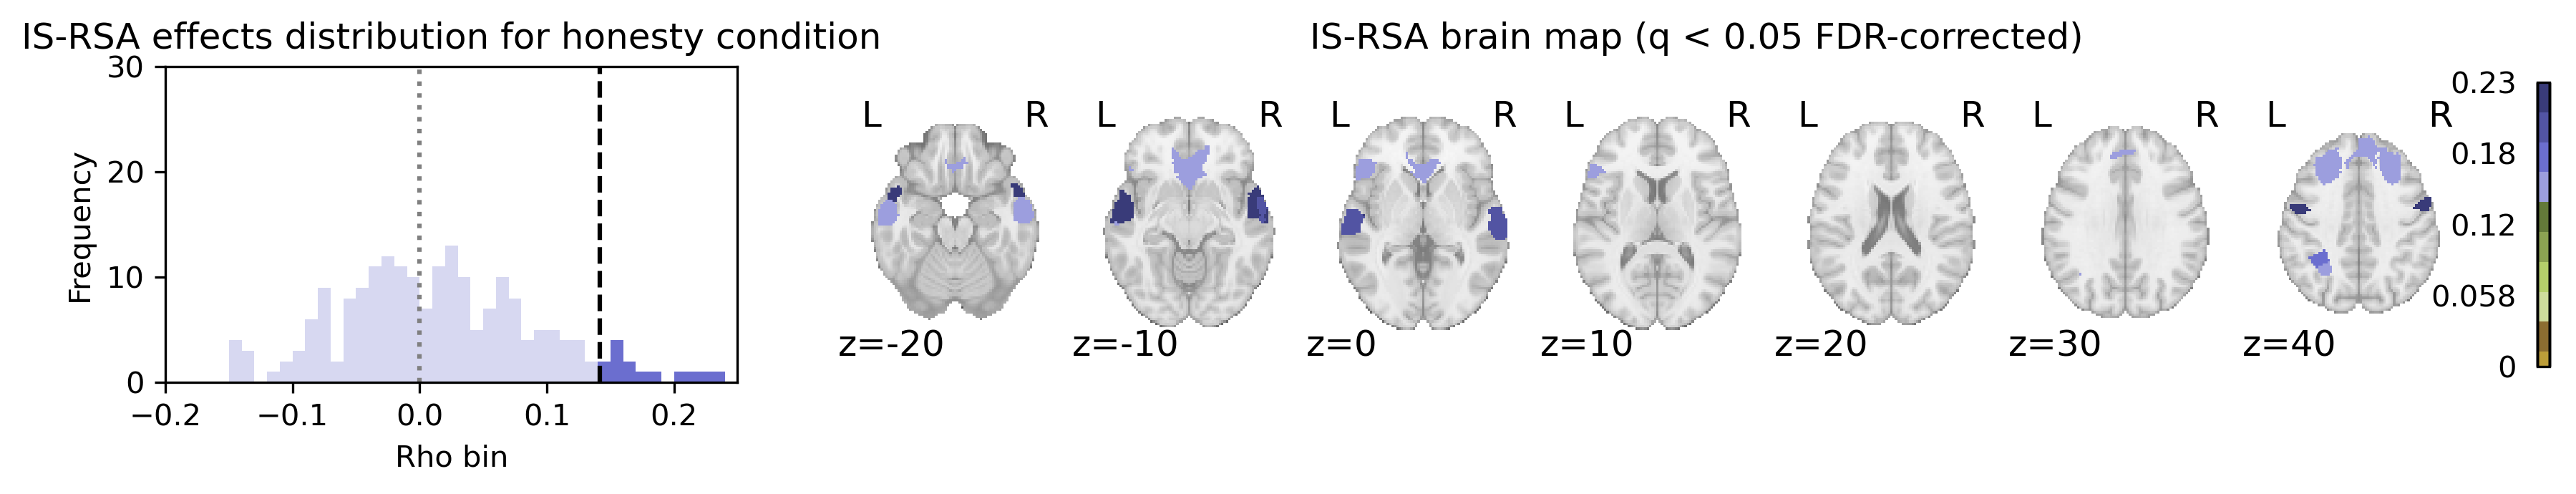

In [73]:
fig,ax = plt.subplots(1,2,figsize=[12,2.4],gridspec_kw={'width_ratios':[1,3]},dpi=300)

permutation_method = 'vector'

from numpy.polynomial.polynomial import polyfit
thresh = 0.05
thresh_type = 'fdr'

map_sim_df = pd.DataFrame(columns=['ISRSA_corr'])
#for ct,runswno in enumerate(runsw):

results = pd.read_csv(os.path.join(fmri_dir,
    '5.RSA/results/IS-RSA_nparcel-%03d_perm-vector_%s'%(nparcel,contrast),'allparcels.csv'),index_col=0)

ISRSA = results['r']
sns.distplot(ISRSA,kde=False,ax=ax[0],bins=bins,color='#9c9ede')
sig_r = results.loc[(results['p']<=fdr(np.array(results['p']),0.05))& (results['r']>0),'r']
r_thresh = np.sort(results.loc[(results['p']<=(fdr(np.array(results['p']),0.05)))& (results['r']>0),'r'].values)[0]
#& (results['r']>0)
ax[0].hist(sig_r,bins=bins,color='#6b6ecf')

ax[0].plot([0,0],[0,50],':',color=[.5,.5,.5])
ax[0].plot([r_thresh,r_thresh],[0,50],'k--')
ax[0].set(title='IS-RSA effects distribution for honesty condition',xlabel='Rho bin',
            ylabel='Frequency',xlim=xlims,ylim=[0,30])
#     ax[ct,0].text(0.09,12,'P < 0.05\n(Bonf.)\nn(sig.) = %i'%len(sig_r))
#ax[0].text(0.09,12,'P < 0.05\n(Fdr.)')

plt.tight_layout();

plot_stat_map(os.path.join(fmri_dir,
            '5.RSA/Maps/Maps_nparcel-%03d_perm-vector/%s_R-thr-0.05-%s-posOnly.nii.gz' % (nparcel,contrast,thresh_type)),
            axes=ax[1],
            display_mode='z',cut_coords=[-20,-10,0,10,20,30,40],cmap='tab20b_r')
ax[1].set(title='IS-RSA brain map (q < 0.05 FDR-corrected)')
map_sim_df = map_sim_df.reset_index(drop=True)
#plt.savefig(os.path.join(base_dir,'Results/3.fMRI-ISRSA/IS-RSA/Maps/ScreenCompare.pdf'))

plt.savefig(os.path.join(fmri_dir,
            '5.RSA/Maps/Maps_nparcel-%i_perm-%s/summary_%s_R-thr-%.2f-%s.svg' % (
            nparcel,permutation_method,contrast,thresh,thresh_type)))
plt.show()


In [32]:
thresh_type

'fdr'

In [49]:
contrast='lie3'

In [50]:
from nilearn.plotting import plot_stat_map


permutation_method = 'vector'

from numpy.polynomial.polynomial import polyfit
thresh = 0.05


all_r = pd.DataFrame(columns=['Parcel','r','p'])

results = pd.read_csv(os.path.join(fmri_dir,
    '5.RSA/results/IS-RSA_nparcel-%03d_perm-vector_%s'%(nparcel,contrast),'allparcels.csv'),index_col=0)

results['Parcel'] = range(nparcel)
all_r = all_r.append(results)
results['r']

0     -0.073083
1     -0.032571
2      0.145804
3      0.089624
4     -0.081336
         ...   
195   -0.149908
196    0.033597
197    0.056724
198    0.160859
199   -0.057938
Name: r, Length: 200, dtype: float64

In [51]:
r_thresh = np.sort(all_r.loc[(all_r['p']<=(fdr(np.array(all_r['p']),0.05))) & (all_r['r']>0),'r'].values)[0]
min_r = np.min(all_r['r'])
max_r = np.max(all_r['r'])
print(min_r,max_r)
xlims = [-.2,.35]
bins = np.arange(-.2,.35,.01)
print(len(bins))

-0.1499084249084249 0.3188122988122988
55


In [ ]:
sns.color_palette('tab20b',14)

[(0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
 (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
 (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
 (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
 (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
 (0.5490196078431373, 0.6352941176470588, 0.3215686274509804),
 (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
 (0.807843137254902, 0.8588235294117647, 0.611764705882353),
 (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
 (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
 (0.9058823529411765, 0.7294117647058823, 0.3215686274509804),
 (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
 (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
 (0.6784313725490196, 0.28627450980392155, 0.2901960784313726)]

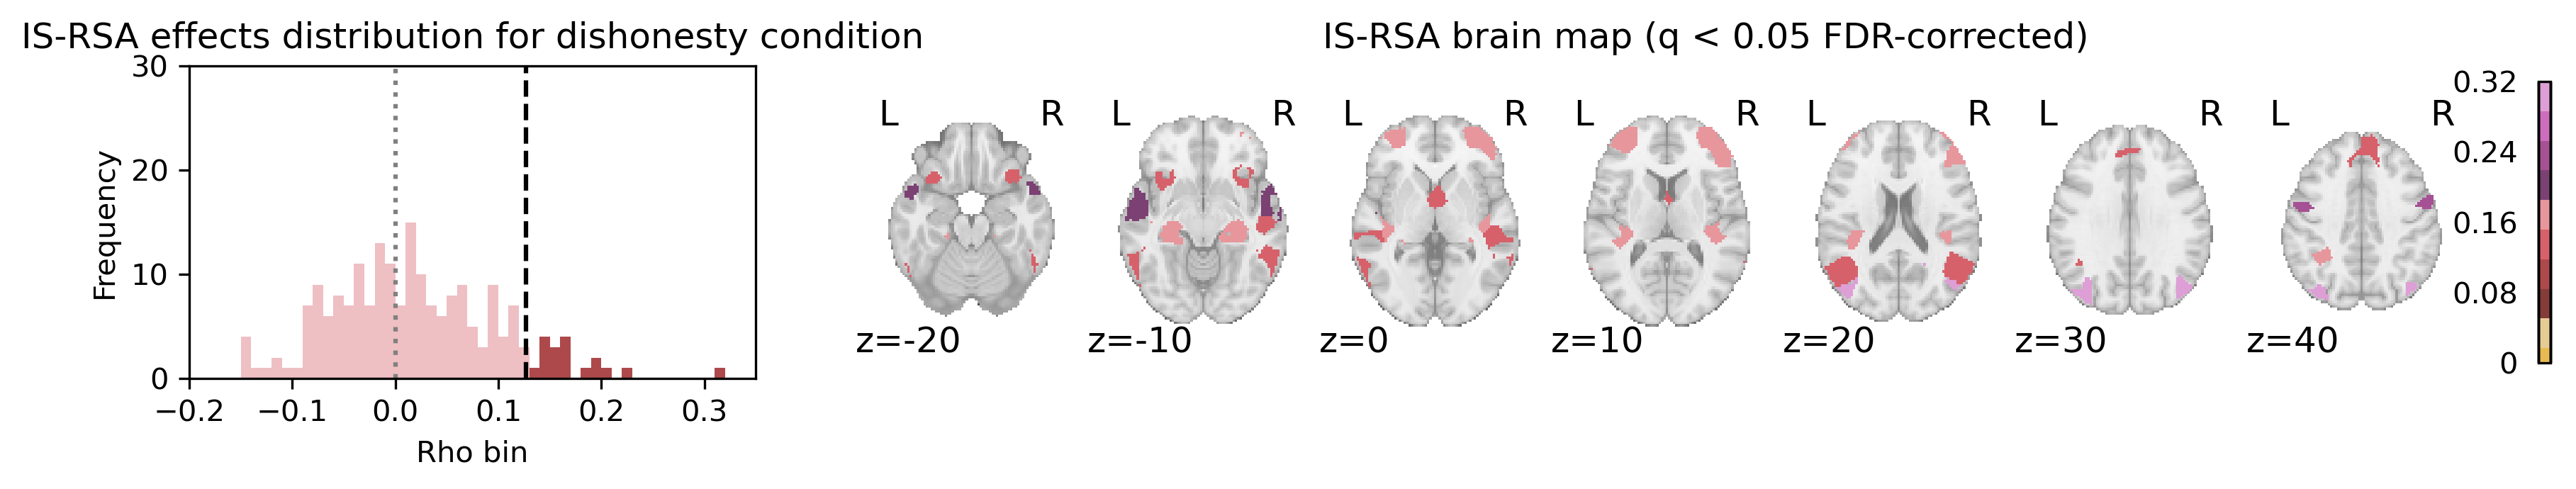

In [57]:
fig,ax = plt.subplots(1,2,figsize=[12,2.4],gridspec_kw={'width_ratios':[1,3]},dpi=300)

permutation_method = 'vector'

from numpy.polynomial.polynomial import polyfit
thresh = 0.05
thresh_type = 'fdr'

map_sim_df = pd.DataFrame(columns=['ISRSA_corr'])
#for ct,runswno in enumerate(runsw):

results = pd.read_csv(os.path.join(fmri_dir,
    '5.RSA/results/IS-RSA_nparcel-%03d_perm-vector_%s'%(nparcel,contrast),'allparcels.csv'),index_col=0)

ISRSA = results['r']
sns.distplot(ISRSA,kde=False,ax=ax[0],bins=bins,color='#d6616b')
sig_r = results.loc[(results['p']<=fdr(np.array(results['p']),0.05))& (results['r']>0),'r']
r_thresh = np.sort(results.loc[(results['p']<=(fdr(np.array(results['p']),0.05)))& (results['r']>0),'r'].values)[0]
#& (results['r']>0)
ax[0].hist(sig_r,bins=bins,color='#ad494a')
ax[0].plot([0,0],[0,50],':',color=[.5,.5,.5])
ax[0].plot([r_thresh-0.01,r_thresh-0.01],[0,50],'k--')
ax[0].set(title='IS-RSA effects distribution for dishonesty condition',xlabel='Rho bin',
            ylabel='Frequency',xlim=xlims,ylim=[0,30])
#     ax[ct,0].text(0.09,12,'P < 0.05\n(Bonf.)\nn(sig.) = %i'%len(sig_r))
#ax[0].text(0.09,12,'P < 0.05\n(Fdr.)')

plt.tight_layout();

plot_stat_map(os.path.join(fmri_dir,
            '5.RSA/Maps/Maps_nparcel-%03d_perm-vector/%s_R-thr-0.05-%s-posOnly.nii.gz' % (nparcel,contrast,thresh_type)),
            axes=ax[1],
            display_mode='z',cut_coords=[-20,-10,0,10,20,30,40],cmap='tab20b')
ax[1].set(title='IS-RSA brain map (q < 0.05 FDR-corrected)')
map_sim_df = map_sim_df.reset_index(drop=True)
#plt.savefig(os.path.join(base_dir,'Results/3.fMRI-ISRSA/IS-RSA/Maps/ScreenCompare.pdf'))

plt.savefig(os.path.join(fmri_dir,
            '5.RSA/Maps/Maps_nparcel-%i_perm-%s/summary_%s_R-thr-%.2f-%s.svg' % (
            nparcel,permutation_method,contrast,thresh,thresh_type)))
plt.show()
